# Before the test starts

In this notebook we will explore the typical work you would do when working with a team to plan an A/B test. 

All data needed can be found in the directory `data/`. 

First, let's load all necessary libraries and the data. 

In [11]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

custom_params = {"axes.spines.right": False, "axes.spines.top": False, 'figure.figsize':(14, 8)}
sns.set_theme(style="whitegrid", rc=custom_params, palette='dark')

In [12]:
sessions = pd.read_csv("../data/pre_sessions.csv", parse_dates=['visit_started_at'])
cart_visits = pd.read_csv("../data/pre_payment_page_visits.csv", parse_dates=['payment_page_accessed_at'])
purchases = pd.read_csv("../data/pre_purchases.csv", parse_dates=['purchase_processed_at'])

In [13]:
print(f"sessions size: {len(sessions):,} \npayment_page_visits size: {len(cart_visits):,}\npurchases size: {len(purchases):,} ")

sessions size: 67,297 
payment_page_visits size: 26,886
purchases size: 21,492 


In [14]:
## Explore the tables. Do they have a common key to be joined on?

## Task 1: Help the Product Manager decide on a key decision metric.

- Where are we at right now on the different metrics?
- Which one do we expect to move the most and by how much?
- What would be the material impact of each? $$$

**How many visitors do we get per day, in general?**
- Visualize unique sessions over time
- What countries are they from? What platforms?

In the end, keep only the data that is relevant to our experiment (IT, ES, Mobile apps)

In [15]:
df = sessions.merge(cart_visits, 
                    how='left', 
                    on=['session_id', 'user_id']).merge(purchases, 
                                                        how='left', 
                                                        on=['session_id', 'user_id'])

In [16]:
def clean_platform(platform:str):
    """
    Returns whether a user is on Android, iOS or any kind of Desktop. Ignores if it's app or mobile web. 
    """
    if 'Android' in platform:
        return 'android'
    if ('iPad' in platform) or ('iPhone' in platform):
        return 'ios'
    else:
        return 'desktop-other'

In [17]:
df['platform_clean'] = df.platform.apply(lambda x: clean_platform(x))

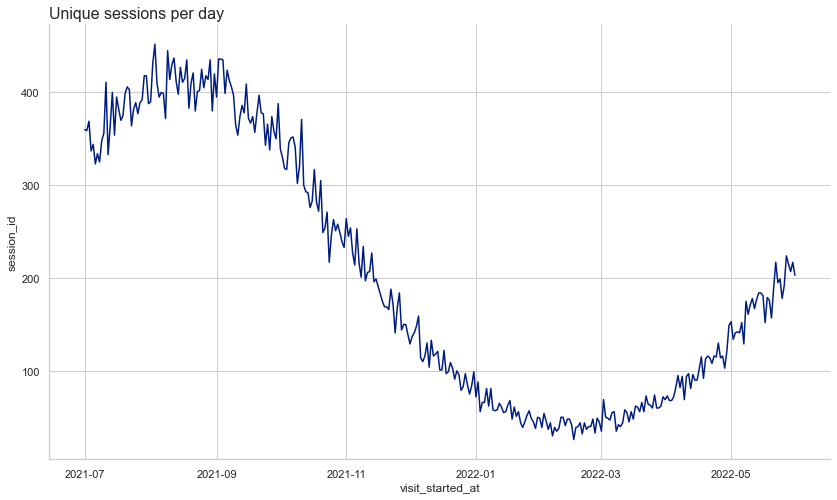

In [18]:
by_date = df.groupby([df.visit_started_at.dt.date]).session_id.nunique()
sns.lineplot(data=by_date)
plt.title("Unique sessions per day", loc='left', size=16)
plt.show()

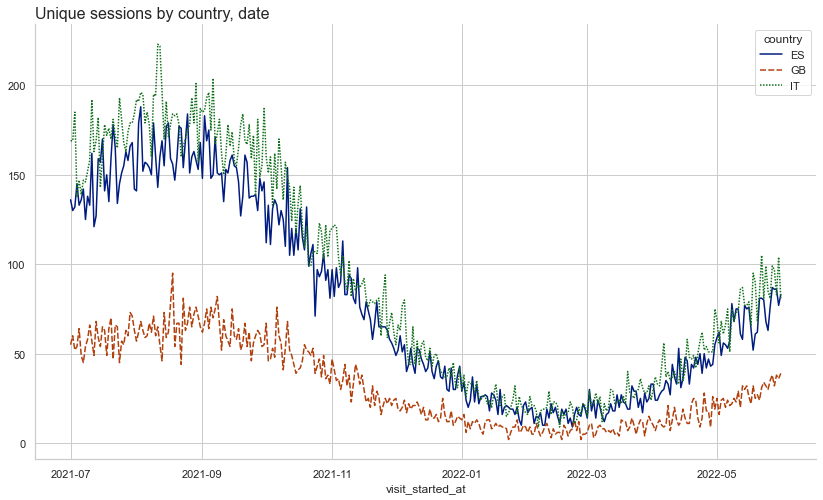

In [19]:
by_date_country = df.groupby([df.visit_started_at.dt.date, df.country]).session_id.nunique().unstack()
sns.lineplot(data=by_date_country)
plt.title("Unique sessions by country, date", loc='left', size=16)
plt.show()

In [20]:
from datetime import timedelta, datetime

Calculate how many unique visits we have per day. How many if we only keep the relevant user subsegment? (IT, ES, Mobile devices). 

In [23]:
daily_visitors = df.groupby([df.visit_started_at.dt.date]).session_id.nunique().mean()
daily_visitors_recent = df[df.visit_started_at > df.visit_started_at.max() - timedelta(days=30)]\
                            .groupby([df.visit_started_at.dt.date])\
                            .session_id\
                            .nunique()\
                            .mean()
print(f"On an average day, we have {daily_visitors:.2f} visitors")
print(f"In the last 30 days, we had on average {daily_visitors_recent:.2f} daily visitors")

On an average day, we have 200.78 visitors
In the last 30 days, we had on average 171.55 daily visitors


In [24]:
subset = df[(df.country.isin(['IT', 'ES'])) & (df.platform_clean.isin(['ios', 'android']))]

daily_visitors = subset.groupby([subset.visit_started_at.dt.date]).session_id.nunique().mean()
daily_visitors_recent = subset[subset.visit_started_at > subset.visit_started_at.max() - timedelta(days=30)]\
                            .groupby([subset.visit_started_at.dt.date])\
                            .session_id\
                            .nunique()\
                            .mean()
print("IF WE CONSIDER ONLY THE RELEVANT SEGMENT...")
print(f"On an average day, we have {daily_visitors:.2f} visitors")
print(f"In the last 30 days, we had on average {daily_visitors_recent:.2f} daily visitors")

IF WE CONSIDER ONLY THE RELEVANT SEGMENT...
On an average day, we have 107.26 visitors
In the last 30 days, we had on average 91.71 daily visitors


**How many make it to the payment page?**
- Describe the payment_page state in general
    - What country are the cart visitors from?
    - What devices do they come from?
    - What is the typical basket volume, value?

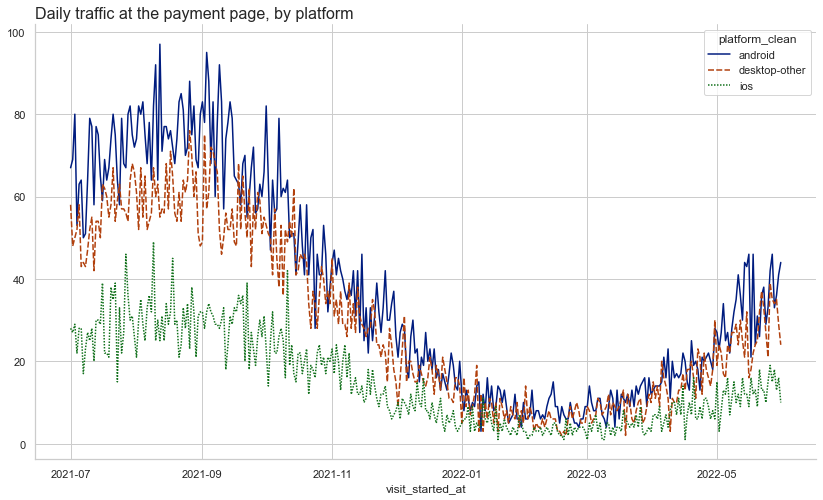

In [26]:
by_date_platform = df[~df.payment_page_accessed_at.isna()]\
                        .groupby([df.visit_started_at.dt.date, 'platform_clean'])\
                        .session_id\
                        .nunique()\
                        .unstack()
sns.lineplot(data=by_date_platform)
plt.title("Daily traffic at the payment page, by platform", loc='left', size=16)
plt.show()

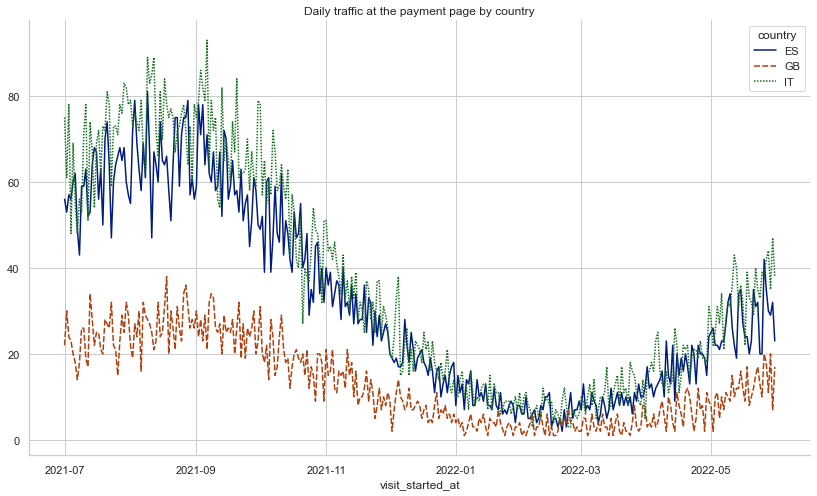

In [27]:
by_date_country = df[~df.payment_page_accessed_at.isna()]\
                        .groupby([df.visit_started_at.dt.date, 'country'])\
                        .session_id\
                        .nunique()\
                        .unstack()
sns.lineplot(data=by_date_country)
plt.title("Daily traffic at the payment page by country")
plt.show()

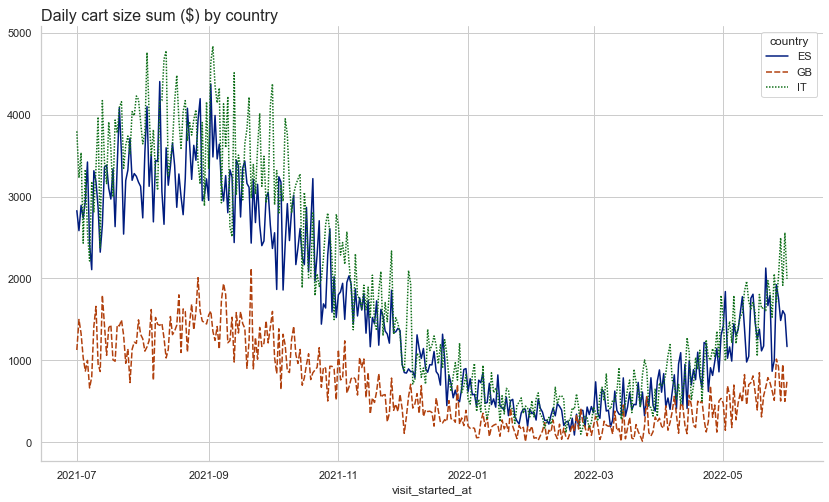

In [29]:
by_date_country_sum_cart = df[~df.payment_page_accessed_at.isna()]\
                        .groupby([df.visit_started_at.dt.date, 'country'])\
                        .cart_size_eur.sum()\
                        .unstack()
sns.lineplot(data=by_date_country_sum_cart)
plt.title("Daily cart size sum ($) by country", loc='left', size=16)
plt.show()

**Summarize per country, device, how many unique sessions we have, the mean and std of the cart size**

In [30]:
df[~df.payment_page_accessed_at.isna()]\
    .groupby(['country', 'platform_clean'])[['session_id', 'cart_size_eur']]\
    .agg({'session_id': ['count'],
          'cart_size_eur': ['mean', 'std']})

session_id cart_size_eur           
                            count          mean        std
country platform_clean                                    
ES      android              4906     50.113705  22.564933
        desktop-other        4017     49.919988  22.096331
        ios                  2048     49.488408  22.256782
GB      android              2066     50.559065  22.965617
        desktop-other        1650     50.072763  22.314038
        ios                   811     50.406057  23.732697
IT      android              5746     50.430800  22.934291
        desktop-other        4528     49.611759  22.129954
        ios                  2330     50.265446  21.600848

**How many of them are repeat, how many new?**
- Look at `last_purchase` column to determine if the user is new or old

In [31]:
df['new_repeat'] = df['last_purchase'].apply(lambda x: 'new' if pd.isna(x) else 'repeat')

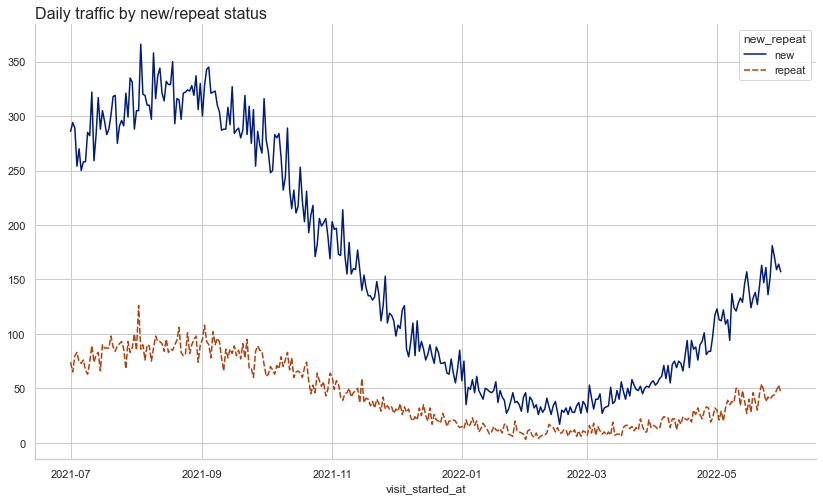

In [32]:
by_date_new_repeat = df.groupby([df.visit_started_at.dt.date, 'new_repeat'])['session_id']\
                       .nunique()\
                       .unstack()
sns.lineplot(data=by_date_new_repeat)
plt.title("Daily traffic by new/repeat status", loc='left', size=16)
plt.show()

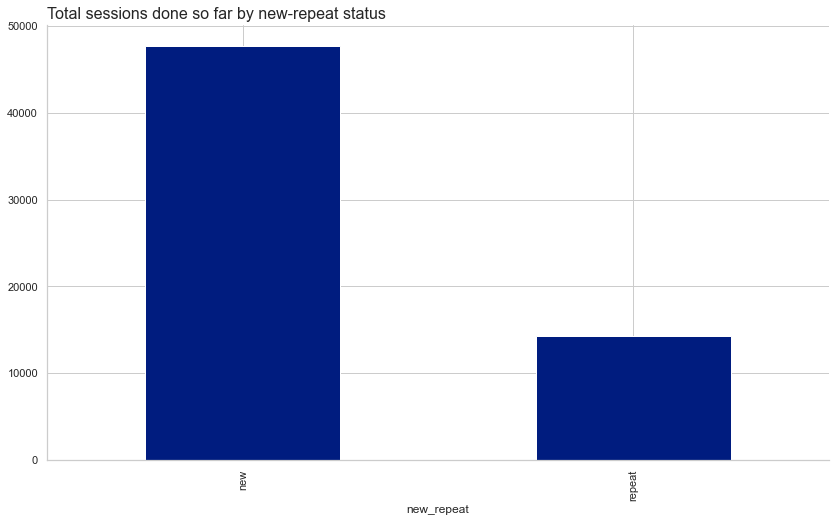

In [33]:
df.groupby('new_repeat')['session_id'].nunique().plot(kind='bar')
plt.title("Total sessions done so far by new-repeat status", loc='left', size=16)
plt.show()

**What is the cart conversion rate?**
- Does it differ by platform or payment methods used?
- What is the payment error rate?

Hint: look at the `success` column

In [35]:
# Calculate a column for conversion rate to purchase for those that accessed the cart
df['converted'] = ~df.payment_page_accessed_at.isna() & ~df.purchase_processed_at.isna()
# Calculate a column for conversation rate to successful purchase for those that accessed the cart
df['converted_success'] = (df.converted) & (df.status=='success')

In [36]:
df[~df.payment_page_accessed_at.isna()][['converted', 'converted_success']].agg(['mean', 'std'])

,converted,converted_success
mean,0.805957,0.680877
std,0.395469,0.466145


In [37]:
df[~df.payment_page_accessed_at.isna()].groupby('platform_clean')[['converted', 'converted_success']].agg(['mean', 'std'])

converted           converted_success          
                    mean       std              mean       std
platform_clean                                                
android         0.806023  0.395427          0.685878  0.464183
desktop-other   0.808337  0.393628          0.676606  0.467795
ios             0.801118  0.399198          0.677009  0.467664

In [52]:
# What percent of all payments ended up in an error?
df[df.converted]\
    .assign(was_error = lambda x: x.status=='error')\
    .groupby('platform_clean')['was_error']\
    .agg(['mean', 'std'])

,mean,std
platform_clean,,
android,0.059311,0.236218
desktop-other,0.063342,0.243592
ios,0.058696,0.235083


In [41]:
# Is there one payment method in particular that is performing worse than others in terms of error rates?
df[df.converted].assign(was_error = lambda x: x.status=='error').groupby('payment_method_selected')['was_error'].agg(['mean', 'std'])

,mean,std
payment_method_selected,,
Giropay,0.062789,0.242619
PayPal,0.062562,0.242198
bank_transfer,0.055087,0.228178
debit_credit_card,0.061218,0.239742


**What are some metrics that could be useful to evaluate adding a new payment method?**
- Think of the action that we want to drive or the problem that we need to solve. 

_________

Now we can finally just use the relevant data!!!

**Step 1**

Keep only the data you want to use. That is, filter down to country in [IT, ES] and platform in [android, ios].


**Step 2** 

Calculate and visualize over time:

- Visit > payment rate
- Visit > successful payment rate
- Cart visit > payment rate
- Cart visit > successful payment rate
- Average order volume (cart size) processed (purchased)
- % of purchases that fail (`status`="error")

**Thought exercise: what do you think could be a reasonable effects size for each of the above?**

In [42]:
# Create a subset of all the data, with only what you want to use in the end. 
subset = df[(df.country.isin(['IT', 'ES'])) & (df.platform_clean.isin(['ios', 'android']))]
subset.shape

(36368, 19)

In [43]:
# Visit > payment rate and visit > successful payment rate
visit_to_payment_rate_over_time = subset\
                                    .groupby(subset.visit_started_at.dt.date)[['converted', 'converted_success']]\
                                    .mean()

In [44]:
visit_to_payment_rate_over_time.head()

,converted,converted_success
visit_started_at,,
2021-07-01,0.340426,0.281915
2021-07-02,0.328125,0.307292
2021-07-03,0.380952,0.333333
2021-07-04,0.284848,0.260606
2021-07-05,0.368750,0.306250


In [46]:
# Cart visit > payment rate and Cart visit > successful payment rate

cart_visit_to_payment_rate_over_time = subset[~subset.payment_page_accessed_at.isna()]\
                                            .groupby(subset[~subset.payment_page_accessed_at.isna()].visit_started_at.dt.date)\
                                            [['converted', 'converted_success']]\
                                            .mean()
cart_visit_to_payment_rate_over_time

,converted,converted_success
visit_started_at,,
2021-07-01,0.790123,0.654321
2021-07-02,0.828947,0.776316
2021-07-03,0.842105,0.736842
2021-07-04,0.758065,0.693548
2021-07-05,0.737500,0.612500
...,...,...
2022-05-27,0.826087,0.826087
2022-05-28,0.913043,0.782609
2022-05-29,0.804878,0.731707


In [47]:
cart_visit_to_payment_rate = subset[~subset.payment_page_accessed_at.isna()][['converted', 'converted_success']].mean()
cart_visit_to_payment_rate

converted            0.802329
converted_success    0.680040
dtype: float64

In [48]:
# Average order volume processed
avg_order_size_over_time = subset[~subset.payment_page_accessed_at.isna()]\
                                .groupby(subset[~subset.payment_page_accessed_at.isna()].visit_started_at.dt.date)\
                                ['cart_size_eur']\
                                .mean()
avg_order_size_over_time

visit_started_at
2021-07-01    51.905238
2021-07-02    49.391478
2021-07-03    48.322556
2021-07-04    48.919709
2021-07-05    49.949858
                ...    
2022-05-27    45.549698
2022-05-28    55.785399
2022-05-29    53.225101
2022-05-30    52.368602
2022-05-31    53.343778
Name: cart_size_eur, Length: 335, dtype: float64

## Task 2: Determine how long the test will need to be run for

Now that we've explored some possible metrics, let's try to estimate how many samples we would need in order to detect the desired effect size in each. For simplicity, let's assume that you are still debating between using as the **primary decision metric**: 

- Visit > payment rate
- Cart visit > successful payment rate

**Thought exercise: What are the pros and cons of each?**

**Visit > payment rate**

Pros:

- just `visit` has a lot more traffic than `cart_visit`
- might be more closely related to high-level metrics tracked by the business, such as "visit > sale"

Cons:

- the baseline conversion rate is quite small, so it will be harder to detect the same effect size as with a metric where the conversion rate is higher
- the actual experiment is implemented on the payment page / cart, so you should see no impact at all on visit > cart (unless it's advertised earlier in the funnel), effectively watering down the results  of the specific experiment. 
- does not take into account if the actual payment failed, only that the user attemped to make a payment

**Cart visit > successful payment rate**

Pros: 

- directly measures what the experiment is trying to capture: "does adding a new payment method make people more likely to successfully purchase?"
- baseline conversion will be higher than if you were starting from `visit`, which means you need fewer samples to detect the same effect size. 
- accounts for errors or failures of the existing payment methods

Cons: 

- the `cart_visit` volume will be lower, so you need to balance that out with the conversion rate. 
- does not directly translate to the high-level business metrics (such as "visit > sale") 

**Define your inputs**

See the typical formula

![sample_size](../img/sample_size_formula.png)

In [50]:
power = 0.8
alpha = 0.05
p_1 = subset['converted'].mean()
p_2 = subset[~subset.payment_page_accessed_at.isna()]['converted_success'].mean()

rel_effect_sizes = [0.01, 0.02, 0.05, 0.1, 0.2, 0.3, 0.5]

**What is a reasonable daily average traffic to assume?**
- Hint: the T-test assumes that observations are independent of each other. But what if a user comes in multiple times?

In [53]:
# Calculate average daily traffic for Visit > payment rate metric
traffic_1 = subset.groupby(subset.visit_started_at.dt.date)\
                  .session_id\
                  .nunique()\
                  .mean()

# Calculate average daily traffic for Cart visit > successful payment rate metric
traffic_2 = subset[~subset.payment_page_accessed_at.isna()]\
                    .groupby(subset.visit_started_at.dt.date)\
                    .session_id\
                    .nunique()\
                    .mean()

In [54]:
print(f"Visit > payment has a baseline of {p_1:.2%} and there are {traffic_1:.2f} visits per day")
print(f"Cart visit > successful payment has a baseline of {p_2:.2%} and there are {traffic_2:.2f} visits per day")

Visit > payment has a baseline of 33.16% and there are 107.26 visits per day
Cart visit > successful payment has a baseline of 68.00% and there are 43.58 visits per day


**What is the number of observations you need to measure effect size Delta, for each of the metrics?**

Here we will finally use `statsmodels` to calculate the desired effect size. 

We will use [`statsmodels.stats.power.tt_ind_solve_power`](https://www.statsmodels.org/dev/generated/statsmodels.stats.power.tt_ind_solve_power.html), which is a pretty neat method in `statsmodels` that outputs whatever is missing from the following: 
- alpha
- power
- n observations
- standardized_effect_size

Note that the effect size has to be expressed as: "difference between the two means divided by the standard deviation". In the case of the binomial distribution (which is the case here), the standard deviation is equal to `sqrt(p*(1-p))`. We will write a custom function to help us with that transformation. 

In [55]:
from statsmodels.stats.power import tt_ind_solve_power
import math

In [56]:
def get_effect_size_proportions(diff: float, p:float):
    """Gets appropriately transformed effect size for proportions. This means
    absolute difference between the two means divided by the standard deviation"""
    return abs(diff)/math.sqrt(p*(1-p))

In [58]:
def calculate_power_table(p_baseline:float, 
                          rel_effect_sizes: list, 
                          daily_visitors:float, 
                          power:float=0.8, 
                          alpha:float=0.05):
    """Generates a table showing the expected duration of the experiment for different effect sizes,
    given an provided daily traffic rate. Assumes traffic remains constant over the duration of the
    experiment."""
    abs_effect_sizes = [p_baseline*(1+i) - p_baseline for i in rel_effect_sizes]
    transformed_effect_sizes = [get_effect_size_proportions(e, p_baseline) for e in abs_effect_sizes]
    
    sample_sizes = [round(2*tt_ind_solve_power(effect_size=e, 
                                       alpha=alpha, 
                                       power=power, 
                                       alternative='two-sided'), 2) for e in transformed_effect_sizes]
    durations_days = [round(s / daily_visitors, 2) for s in sample_sizes]
    durations_weeks = [round(d / 7, 2) for d in durations_days]
    
    return pd.DataFrame({'baseline': p_baseline,
                         'rel_effect_size': rel_effect_sizes,
                         'abs_effect_size': abs_effect_sizes,
                         'alpha': alpha,
                         'power': power,
                         'sample_size_required': sample_sizes,
                         'days_required': durations_days,
                         'weeks_required': durations_weeks})
    

In [59]:
# print table for Visit > payment rate
calculate_power_table(p_baseline=p_1,
                      rel_effect_sizes=rel_effect_sizes,
                      daily_visitors=traffic_1,
                      power=power,
                      alpha=alpha)

,baseline,rel_effect_size,abs_effect_size,alpha,power,sample_size_required,days_required,weeks_required
0,0.331583,0.01,0.003316,0.05,0.8,632883.43,5900.48,842.93
1,0.331583,0.02,0.006632,0.05,0.8,158222.30,1475.13,210.73
2,0.331583,0.05,0.016579,0.05,0.8,25317.18,236.04,33.72
3,0.331583,0.10,0.033158,0.05,0.8,6330.74,59.02,8.43
4,0.331583,0.20,0.066317,0.05,0.8,1584.13,14.77,2.11
5,0.331583,0.30,0.099475,0.05,0.8,705.13,6.57,0.94
6,0.331583,0.50,0.165791,0.05,0.8,255.09,2.38,0.34


In [60]:
# print table Cart visit > successful payment rate
calculate_power_table(p_baseline=p_2,
                      rel_effect_sizes=rel_effect_sizes,
                      daily_visitors=traffic_2,
                      power=power,
                      alpha=alpha)

,baseline,rel_effect_size,abs_effect_size,alpha,power,sample_size_required,days_required,weeks_required
0,0.68004,0.01,0.006800,0.05,0.8,147718.08,3389.65,484.24
1,0.68004,0.02,0.013601,0.05,0.8,36930.96,847.45,121.06
2,0.68004,0.05,0.034002,0.05,0.8,5910.57,135.63,19.38
3,0.68004,0.10,0.068004,0.05,0.8,1479.08,33.94,4.85
4,0.68004,0.20,0.136008,0.05,0.8,371.22,8.52,1.22
5,0.68004,0.30,0.204012,0.05,0.8,166.07,3.81,0.54
6,0.68004,0.50,0.340020,0.05,0.8,61.07,1.40,0.20


**Put it all together**

Based on the discussion above, what would you recommend?

- There is no black or white answer here.
- Personally, I would lean more towards the `Cart visit > successful payment rate` metric as the primary decision metric for the experiment, as this is the behaviour we want to directly influence through this experiment. 
- We can always use the other metrics as secondary or supportive metrics. You can read more about how Optimizely, one of the most popular experimentation SaaS platforms, suggests you define primary and secondary metrics and monitoring goals ("do no harm"): [Primary and secondary metrics and monitoring goals](https://support.optimizely.com/hc/en-us/articles/4410283160205-Primary-and-secondary-metrics-and-monitoring-goals) 

## Task 3: Finalize the experiment plan

Here, simply write down what you are going to propose to the product manager. 

- Experiment name: 
- Hypothesis formulation:
- Platform: 
- Users targeted:
- Primary decision metric:
- Baseline of this metric in the last {} months:
- Expected effect size (relative): 
- Expected experiment duration: 